In [1]:
import numpy as np
import sys
import math
from scipy.stats import norm

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.mlab import griddata

sys.path.append('..')
from higgs_inference import settings

In [2]:
data_dir = '../data'
figure_dir = '../figures/morphing'

thetas = settings.thetas
theta1 = settings.theta1_default

xi = np.linspace(-1.0, 1.0, settings.n_thetas_roam)
yi = np.linspace(-1.0, 1.0, settings.n_thetas_roam)
xx, yy = np.meshgrid(xi, yi)
thetas_eval = np.asarray(list(zip(xx.flatten(), yy.flatten())))

r_eval = np.load('../results/truth/r_roam_truth.npy')[1]
r_thetas = np.load('../results/truth/r_roam_thetas_truth.npy')[:,1]


In [3]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.08
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8., panel_aspect_ratio=1.):
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels - 1)*margin_sep_total) / n_panels
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    
    # Calculate horizontal margins. Units: relative to width.
    height = panel_height_absolute + margin_t_absolute + margin_b_absolute
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8., panel_aspect_ratio=1.):
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels - 1)*margin_sep_total) / n_panels
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    
    # Calculate horizontal margins. Units: relative to width.
    height = panel_height_absolute + margin_t_absolute + margin_b_absolute
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace)
    
print(calculate_height(2,8.))
print(calculate_height(3,9.))

3.2800000000000007
2.466666666666667


# Morphing weights

In [4]:
# Morphing
n_samples = 15

def calculate_wtilde(t, component_sample):
    wtilde_components = np.asarray([
        1. + 0. * t[:, 0],
        t[:, 1],
        t[:, 1] * t[:, 1],
        t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 1] * t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 0],
        t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 0],
        t[:, 0] * t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 0],
        t[:, 0] * t[:, 0] * t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 0] * t[:, 0]
    ]).T
    return wtilde_components.dot(component_sample)


def calculate_wi(t, component_sample, sigma_sample, sigma_component):
    wtildes = calculate_wtilde(t, component_sample)
    sigma_wtildes = sigma_sample * wtildes # (?, 15)
    
    denom = np.ones_like(sigma_wtildes.T) # (?, 15)
    denom[:,:] /= np.sum(sigma_wtildes, axis=1)
    denom = denom.T
    
    return (sigma_wtildes * denom).T

# Suboptimal morphing setup

In [6]:
thetas_morphing = np.array([
    [0.,0.],
    [0.,0.25],
    [0.,0.5],
    [0.,0.75],
    [0.,1.],
    [0.25,0.],
    [0.25,0.25],
    [0.25,0.5],
    [0.25,0.75],
    [0.5,0.],
    [0.5,0.25],
    [0.5,0.5],
    [0.75,0.],
    [0.75,0.25],
    [1.,0.]
])

sigma_component = np.load(data_dir + '/morphing/component_xsec.npy')[1:] # Ignore background component
component_sample = np.load(data_dir + '/morphing/component_sample.npy')[1:] # Ignore background component
sigma_sample = np.linalg.inv(component_sample).dot(sigma_component)

wi_original = calculate_wi(thetas_eval, component_sample, sigma_sample, sigma_component)

wi_original = wi_original.reshape(15,settings.n_thetas_roam,settings.n_thetas_roam)

wi_original_sum = np.sum(wi_original, axis=0)
print(np.min(wi_original_sum), np.max(wi_original_sum))
print(np.var(wi_original))

wi_original = np.clip(wi_original,-1000.,1000.)

0.9999999999996376 1.0000000000003908
9706.890538750884


NameError: name 'wi_original' is not defined

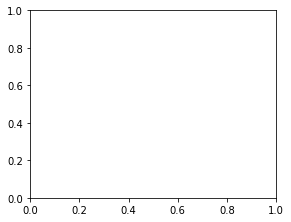

In [4]:
fig = plt.figure(figsize=(15,20))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_original[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                              vmin=-1000.0, vmax=1000.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_morphing[:, 0], thetas_morphing[:, 1],
                marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)
    plt.scatter([thetas_morphing[i, 0]], [thetas_morphing[i, 1]],
                marker='o', c='black', s=50, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1., 1)
    plt.ylim(-1., 1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_original.pdf")

# Better morphing setup (which we actually use)

(-1.1, 1.1)

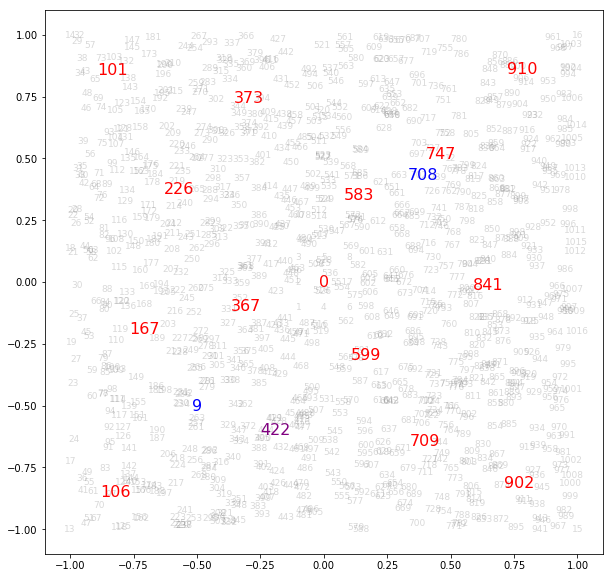

In [5]:
th_morphing = [0, 101, 106, 902, 910,
              226, 373, 583, 747, 841,
              599, 709, 422, 367, 167]

benchmarks = [708, 9, 422]

plt.figure(figsize=(10,10))

for i, theta in enumerate(thetas):
    plt.text(theta[0],theta[1],str(i),
             fontsize = 16 if i in th_morphing or i in benchmarks else 9,
             alpha = 1. if i in th_morphing or i in benchmarks else 0.3,
             color = 'purple' if i in th_morphing and i in benchmarks else 'red' if i in th_morphing else 'blue' if i in benchmarks else 'grey',
             horizontalalignment = 'center',
             verticalalignment = 'center')
    
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

In [6]:
thetas_used_morphing = thetas[th_morphing]

sample_component = np.load(data_dir + '/morphing/components_fakebasis2.npy')[:,1:] # Ignore background component
component_sample = np.linalg.inv(sample_component)
sigma_sample = np.load(data_dir + '/morphing/fakebasis2_xsecs.npy')
sigma_component = component_sample.dot(sigma_sample)

wi_used = calculate_wi(thetas_eval, component_sample, sigma_sample, sigma_component)
wi_used = wi_used.reshape(15,settings.n_thetas_roam,settings.n_thetas_roam)
wi_theta1_used = calculate_wi(np.array([thetas[theta1]]), component_sample, sigma_sample, sigma_component).flatten()

wi_used_sum = np.sum(wi_used, axis=0)
print(np.min(wi_used_sum), np.max(wi_used_sum))
print(np.var(wi_used))

wi_used = np.clip(wi_used,-1000.,1000.)
print(wi_used.shape)

0.9999999999999671 1.0000000000000369
78.04487363252336
(15, 101, 101)


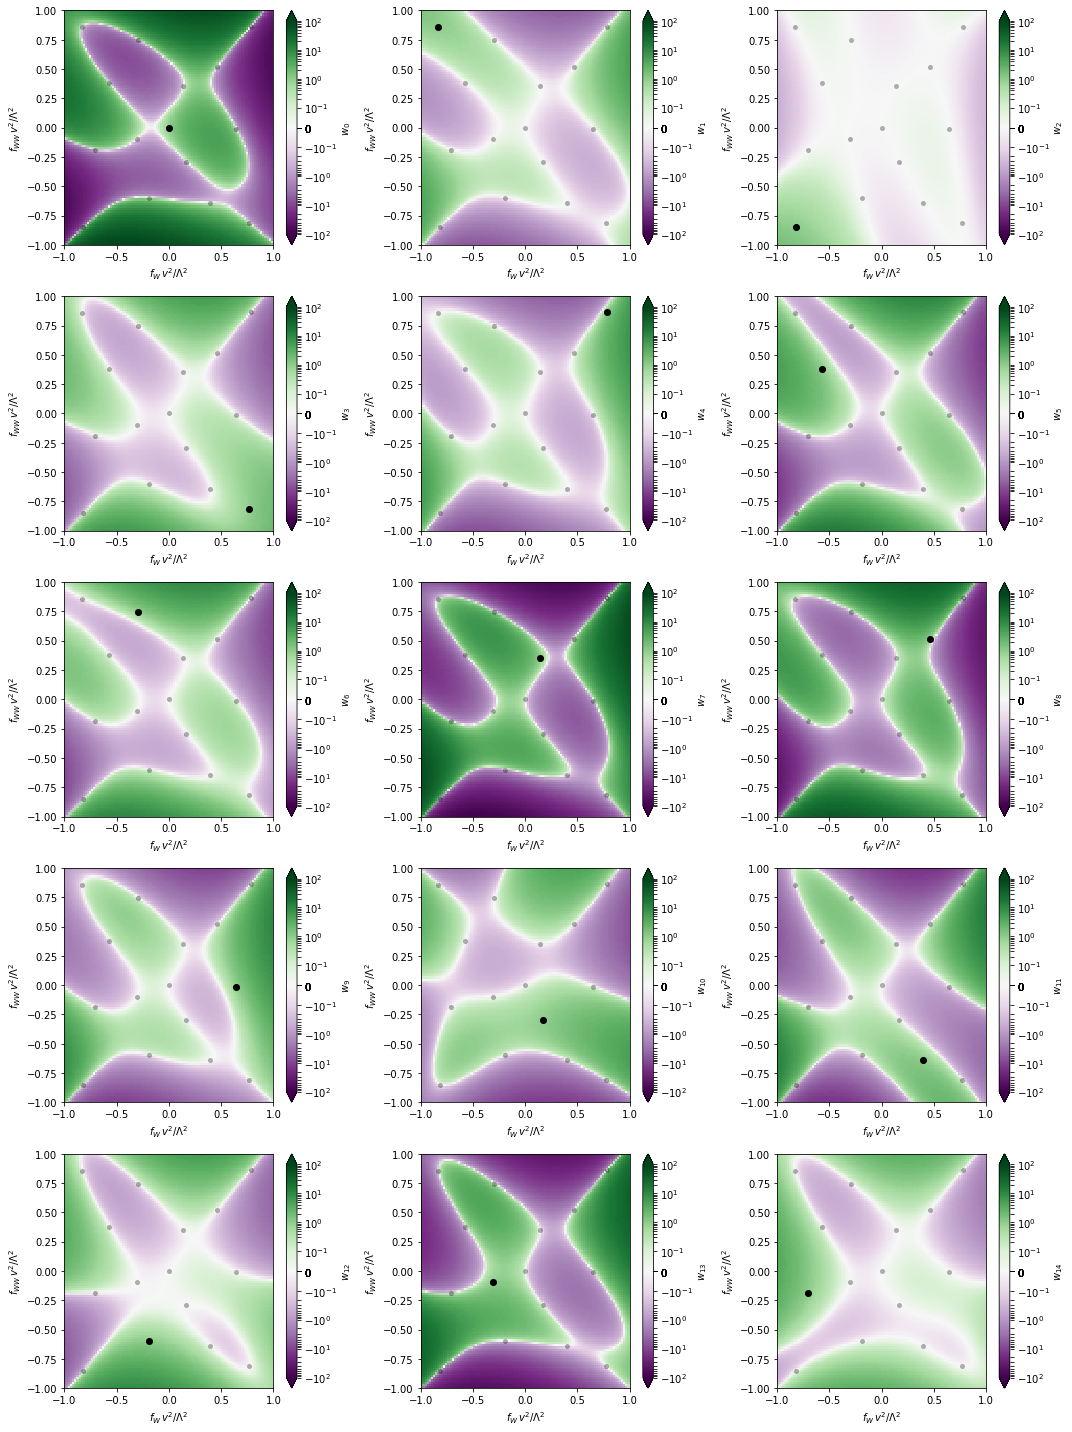

In [7]:
fig = plt.figure(figsize=(15,20))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_used[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                              vmin=-100.0, vmax=100.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
                marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)
    plt.scatter([thetas_used_morphing[i, 0]], [thetas_used_morphing[i, 1]],
                marker='o', c='black', s=50, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_big.pdf")

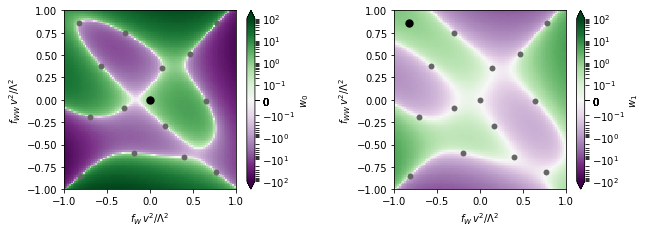

In [30]:
fig = plt.figure(figsize=(9.,calculate_height(2,9.,panel_aspect_ratio=1.2)))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_used[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                              vmin=-100.0, vmax=100.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
                marker='o', c='0.4', s=35, lw=0, zorder=9, alpha=1.)
    plt.scatter([thetas_used_morphing[i, 0]], [thetas_used_morphing[i, 1]],
                marker='o', c='black', s=70, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

adjust_margins(2,9.,panel_aspect_ratio=1.2)
plt.savefig(figure_dir + "/../paper/morphing.pdf")

# Errors from morphing (Gaussian error prop)

In [9]:
def _clip(x, clip=1.e-6):
    y = np.sign(x)*np.clip(np.abs(x),1.e-6,None)
    y[(y<clip) & (y > -clip)] = clip
    return y
    

In [10]:
uncertainty_on_log_r_from_morphing = np.zeros((101, 101))

for i, (wi, thi) in enumerate(zip(wi_used, th_morphing)):
    uncertainty_on_log_r_from_morphing += wi**2 * r_thetas[thi]**2
    
uncertainty_on_log_r_from_morphing = np.sqrt(uncertainty_on_log_r_from_morphing)
uncertainty_on_log_r_from_morphing /= r_eval.reshape((101,101))

print(np.min(uncertainty_on_log_r_from_morphing), np.median(uncertainty_on_log_r_from_morphing), np.max(uncertainty_on_log_r_from_morphing))


0.6711028659588117 9.301092918016097 222.03259011666893


In [11]:
uncertainty_on_log_r_from_decomposition = np.zeros((101, 101))

for i, (wi, wi1, thi) in enumerate(zip(wi_used, wi_theta1_used, th_morphing)):
    for j, (wj, wj1, thj) in enumerate(zip(wi_used[:i], wi_theta1_used[:i], th_morphing[:i])):
    
        denominator1 = np.zeros((101, 101))
        for k, (wk1, thk) in enumerate(zip(wi_theta1_used[:], th_morphing[:])):
            denominator1 += wk1 / _clip(wi) * wk1 * r_thetas[thk] / r_thetas[thi]
        denominator1 = denominator1**2
        
        term1 = wj1 / _clip(wi) * r_thetas[thj] / r_thetas[thi] / denominator1
        
        denominator2 = np.zeros((101, 101))
        for k, (wk1, thk) in enumerate(zip(wi_theta1_used[:], th_morphing[:])):
            denominator2 += wk1 / _clip(wj) * wk1 * r_thetas[thk] / r_thetas[thj]
        denominator2 = denominator2**2
        
        term2 = wi1 / _clip(wj) * r_thetas[thi] / r_thetas[thj] / denominator2
        
        uncertainty_on_log_r_from_decomposition += (term1 - term2)**2
    
uncertainty_on_log_r_from_decomposition = np.sqrt(uncertainty_on_log_r_from_decomposition)
uncertainty_on_log_r_from_decomposition /= r_eval.reshape((101,101))

print(np.min(uncertainty_on_log_r_from_decomposition), np.median(uncertainty_on_log_r_from_decomposition), np.max(uncertainty_on_log_r_from_decomposition))


0.06533213227945195 6.36842959915393 147.46222943084925


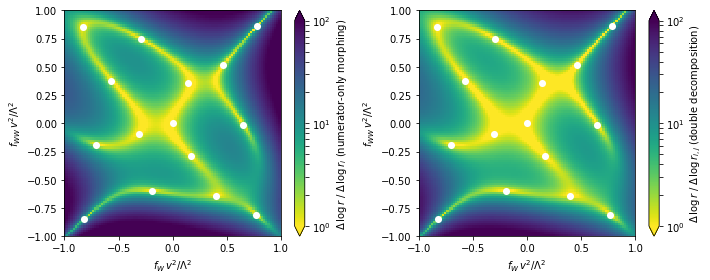

In [12]:
fig = plt.figure(figsize=(10.,4.))

ax = plt.subplot(1,2,1)
pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_morphing,
                   norm=matplotlib.colors.LogNorm(vmin=1., vmax=1.e2),
                   cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=50, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\Delta \, \log \, r \; / \; \Delta \, \log \, r_i$ (numerator-only morphing)')

ax = plt.subplot(1,2,2)
pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_decomposition,
                   norm=matplotlib.colors.LogNorm(vmin=1., vmax=1.e2),
                   cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=50, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\Delta \, \log \, r \; / \; \Delta \, \log \, r_{i,j}$ (double decomposition)')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_uncertainties.pdf")

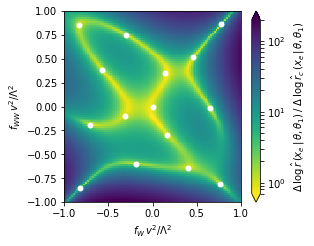

In [33]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,panel_aspect_ratio=1.2)))
ax = plt.gca()

pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_morphing,
                   norm=matplotlib.colors.LogNorm(vmin=0.7, vmax=2e2),
                   cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=35, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\Delta \, \log \, \hat{r} \, (x_e \, | \, \theta, \theta_1) \; / \; \Delta \, \log \, \hat{r}_c \, (x_e \, | \, \theta, \theta_1) $')

adjust_margins(1,4.5)
plt.savefig(figure_dir + "/../paper/morphing_uncertainties.pdf")

# Errors from morphing (toy experiments)

In [48]:
def add_noise(original, noise, relative=False):
    if relative:
        return norm(loc=original, scale=noise*np.abs(original)).rvs(size=original.shape)
    return norm(loc=original, scale=noise).rvs(size=original.shape)


In [49]:
def calculate_log_r_from_morphing(log_ri_noise=0., relative=False):
    
    log_ri = np.log(r_thetas[th_morphing])
    log_ri = add_noise(log_ri, log_ri_noise, relative)
    
    log_r = np.zeros_like(wi_used[0])
    for this_log_ri, this_wi in zip(log_ri, wi_used):
        log_r += this_wi*np.exp(this_log_ri)
    log_r = np.log(log_r)
        
    return log_r

In [50]:
def calculate_log_r_from_double_decomposition(log_ri_noise=0., log_rij_noise=0., relative=False):
    
    log_ri = np.log(r_thetas[th_morphing])
    log_ri = add_noise(log_ri, log_ri_noise, relative)
    log_rij = np.zeros((15,15))
    for i in range(15):
        for j in range(i):
            log_rij[i,j] = log_ri[i] - log_ri[j]
    log_rij = add_noise(log_rij, log_rij_noise, relative)
    for i in range(15):
        log_rij[i,i] = 0.
        for j in range(i):
            log_rij[j,i] = - log_rij[i,j]
    
    log_r = np.zeros_like(wi_used[0])
    for i, (wi, wi1) in enumerate(zip(wi_used, wi_theta1_used)):
        summand = np.zeros_like(wi)
        for j, (wj, wj1) in enumerate(zip(wi_used, wi_theta1_used)):
            summand += wj1 / _clip(wi) * np.exp(log_rij[j,i])
        log_r += 1./summand
        
    log_r = np.log(log_r)
    
        
    return log_r

In [71]:
noise = 0.001

log_r_from_morphing = []
log_r_from_decomposition = []
log_r_from_morphing_relative = []
log_r_from_decomposition_relative = []

for i in range(100):
    log_r_from_morphing.append(calculate_log_r_from_morphing(noise, False))
    log_r_from_decomposition.append(calculate_log_r_from_double_decomposition(0.,noise, False))
    log_r_from_morphing_relative.append(calculate_log_r_from_morphing(noise, True))
    log_r_from_decomposition_relative.append(calculate_log_r_from_double_decomposition(0.,noise, True))

log_r_from_morphing = np.asarray(log_r_from_morphing)
log_r_from_decomposition = np.asarray(log_r_from_decomposition)
log_r_from_morphing_relative = np.asarray(log_r_from_morphing_relative)
log_r_from_decomposition_relative = np.asarray(log_r_from_decomposition_relative)

median_log_r_from_morphing_relative = np.median(log_r_from_morphing_relative, axis=0)
median_log_r_from_decomposition_relative = np.median(log_r_from_decomposition_relative, axis=0)

uncertainty_on_log_r_from_morphing = np.sqrt(np.var(log_r_from_morphing, axis=0)) / noise
uncertainty_on_log_r_from_decomposition = np.sqrt(np.var(log_r_from_decomposition, axis=0)) / noise
uncertainty_on_log_r_from_morphing_relative = np.sqrt(np.var(log_r_from_morphing_relative, axis=0)) / noise / np.abs(median_log_r_from_morphing_relative)
uncertainty_on_log_r_from_decomposition_relative = np.sqrt(np.var(log_r_from_decomposition_relative, axis=0)) / noise / np.abs(median_log_r_from_decomposition_relative)

print(np.min(uncertainty_on_log_r_from_morphing), np.min(uncertainty_on_log_r_from_decomposition))
print(np.mean(uncertainty_on_log_r_from_morphing), np.mean(uncertainty_on_log_r_from_decomposition))
print(np.max(uncertainty_on_log_r_from_morphing), np.max(uncertainty_on_log_r_from_decomposition))


0.6397248953497914 0.08449198164142677
24.48924777245974 23.318368465957324
211.98398644595733 201.31050089665078


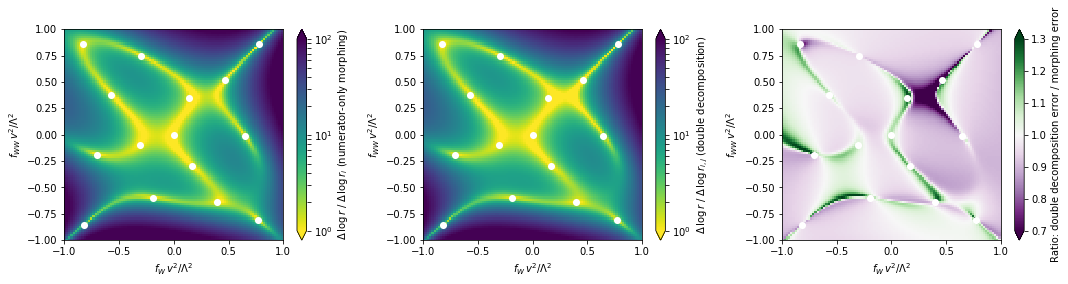

In [72]:
fig = plt.figure(figsize=(15.,4.))

ax = plt.subplot(1,3,1)
pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_morphing,
                   norm=matplotlib.colors.LogNorm(vmin=1., vmax=100.),
                   cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=50, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\Delta \, \log \, r \; / \; \Delta \, \log \, r_i$ (numerator-only morphing)')

ax = plt.subplot(1,3,2)
pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_decomposition,
                   norm=matplotlib.colors.LogNorm(vmin=1., vmax=100.),
                   cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=50, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\Delta \, \log \, r \; / \; \Delta \, \log \, r_{i,j}$ (double decomposition)')

ax = plt.subplot(1,3,3)
pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_decomposition / uncertainty_on_log_r_from_morphing,
                   cmap='PRGn', vmin=0.7,vmax=1.3)
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=50, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'Ratio: double decomposition error / morphing error')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_uncertainties_mc.pdf")

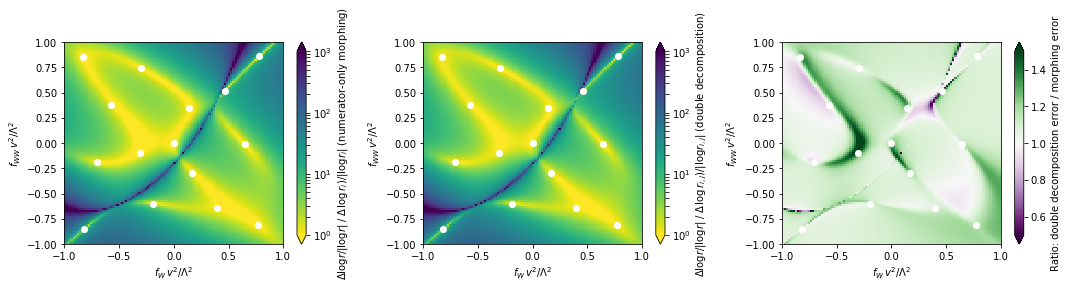

In [74]:
fig = plt.figure(figsize=(15.,4.))

ax = plt.subplot(1,3,1)
pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_morphing_relative,
                   norm=matplotlib.colors.LogNorm(vmin=1., vmax=1000.),
                   cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=50, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\Delta \log r / |\log r| \; / \; \Delta \, \log \, r_i)/|\log r_i|$ (numerator-only morphing)')

ax = plt.subplot(1,3,2)
pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_decomposition_relative,
                   norm=matplotlib.colors.LogNorm(vmin=1., vmax=1000.),
                   cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=50, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\Delta \log r / |\log r| \; / \; \Delta \, \log \, r_{i,j})/|\log r_{i,j}|$ (double decomposition)')

ax = plt.subplot(1,3,3)
pcm = ax.pcolormesh(xi, yi, uncertainty_on_log_r_from_decomposition_relative / uncertainty_on_log_r_from_morphing_relative,
                   cmap='PRGn', vmin=0.5,vmax=1.5)
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='white', s=50, lw=0, zorder=9, alpha=1.)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'Ratio: double decomposition error / morphing error')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_uncertainties_mc_relative.pdf")

# Double-check weights from morphing-aware network 

In [51]:
ri_nottrained = np.load('../results/parameterized/morphing_wi_nottrained_carl_aware_basis.npy')
wi_nottrained = np.load('../results/parameterized/morphing_ri_nottrained_carl_aware_basis.npy')[0]
r_nottrained = np.load('../results/parameterized/r_nottrained_carl_aware_basis.npy')
ri_trained = np.load('../results/parameterized/morphing_wi_trained_carl_aware_basis.npy')
wi_trained = np.load('../results/parameterized/morphing_ri_trained_carl_aware_basis.npy')[0]
r_trained = np.load('../results/parameterized/r_trained_carl_aware_basis.npy')

theta_trained = 422
theta_nottrained = 9

In [46]:
wi_trained_true = calculate_wi(np.asarray([thetas[theta_trained]]),
                               component_sample, sigma_sample, sigma_component).reshape((-1,))
wi_nottrained_true = calculate_wi(np.asarray([thetas[theta_nottrained]]),
                               component_sample, sigma_sample, sigma_component).reshape((-1,))

In [50]:
print(wi_trained)
print(wi_trained_true)
print(wi_trained - wi_trained_true)

print('')

print(wi_nottrained)
print(wi_nottrained_true)
print(wi_nottrained-wi_nottrained_true)

[-1.5685592e-06  1.0774480e-07 -1.7456896e-09 -1.4361480e-07
  9.9741698e-08 -2.6397331e-07 -1.4546788e-07 -7.9567707e-07
 -5.3040907e-07  1.6954810e-07  1.5721119e-07  4.4933245e-07
  1.0000017e+00  9.0055096e-07 -4.9222979e-08]
[ 9.55897104e-16 -4.15251401e-15  7.47922420e-17 -1.16240070e-15
 -4.82470911e-16 -7.45246754e-16 -4.22310107e-16 -2.50232508e-15
 -7.19954388e-15  9.41304907e-15 -3.27380864e-16 -1.38233423e-15
  1.00000000e+00  2.74509145e-15 -1.33322528e-15]
[-1.56855924e-06  1.07744807e-07 -1.74568967e-09 -1.43614797e-07
  9.97416981e-08 -2.63973305e-07 -1.45467879e-07 -7.95677065e-07
 -5.30409061e-07  1.69548092e-07  1.57211190e-07  4.49332448e-07
  1.66893005e-06  9.00550956e-07 -4.92229781e-08]

[-6.8415465   0.32128537  0.144119   -0.26008308  0.17167953 -0.964056
 -0.5357892   4.5098977  -1.6826981   0.46183938  1.0012074   0.44210222
 -0.02847112  4.41144    -0.15092601]
[-6.8415364   0.32128504  0.14411881 -0.26008274  0.17167923 -0.96405491
 -0.53578846  4.50989207

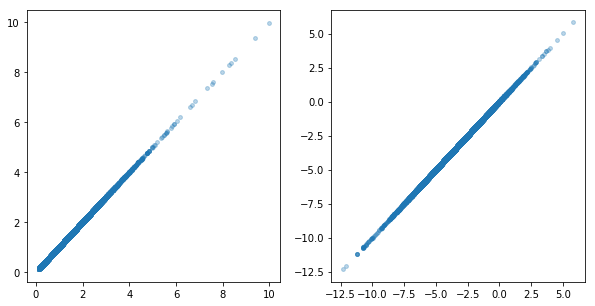

In [61]:
plt.figure(figsize=(10.,5.))

plt.subplot(1,2,1)
plt.scatter(ri_trained[:,12], r_trained, s=15., alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(ri_nottrained.dot(wi_nottrained), r_nottrained, s=15., alpha=0.3)

plt.show()